Test Autocorrelation

Validation for autocorr: Model the process of M—> (k)0, the autocorr should be e^(-kt)

In [1]:
##### test_autocrosscorr_birthdeath.py
import numpy as np
import matplotlib.pyplot as plt
import stochpy
from wela.autocrosscorr import autocrosscorr

smod = stochpy.SSA(model_file="birth_death.psc", dir=".")

# birth rate
k0 = 5
# death rate
d0 = 0.05
# final time of simulation
tf = 1500

# load the stochastic birth-death model
smod.ChangeParameter("k", k0)
smod.ChangeParameter("d", d0)

if False:
    # simulate stochastically
    smod.DoStochSim(end=tf, mode="time", trajectories=3, quiet=False)
    # plot the results
    smod.PlotSpeciesTimeSeries()
    plt.xlim([0, tf])
    plt.show()

# run many simulations
smod.DoStochSim(end=tf, mode="time", trajectories=500, quiet=False)

# put the trajectories on a grid - a matrix - with regularly spaced time points
ns = 1000
dt = np.mean(np.diff(np.linspace(0, tf, ns)))
timesavailable = np.linspace(0, tf, ns)
smod.GetRegularGrid(n_samples=ns)
# each row is one trajectory
data = np.array(smod.data_stochsim_grid.species[0]).astype("float")

# autocorrelation
ac, lags = autocrosscorr(data[:, int(ns / 2) :])
plt.figure()
t = dt * np.arange(int(ns / 2))
plt.plot(dt * lags, np.mean(ac, axis=0), "b-")
plt.plot(t, np.exp(-t * d0), "k--")
plt.grid()
plt.show()


AttributeError: module 'numpy' has no attribute 'MachAr'

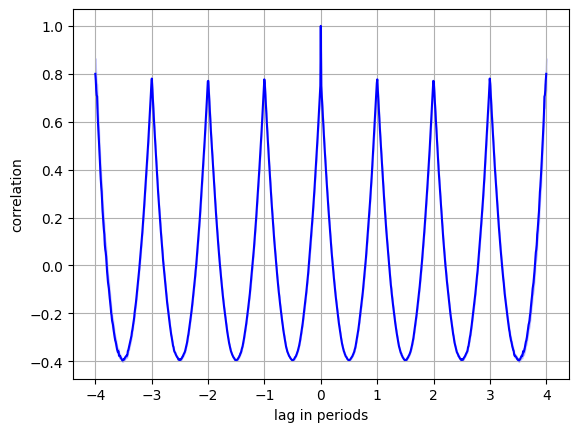

In [ ]:
# test_autocrosscorr_sawtooth.py
import numpy as np
from scipy import signal
from wela.autocrosscorr import autocrosscorr
from matplotlib import pyplot as plt

def plot_replicate_array(
    data,
    t=None,
    plotmean=True,
    xlabel=None,
    ylabel=None,
    title=None,
    grid=True,
    showdots=False,
    show=True,
):
    """
    Plot summary statistics versus axis 1 (time) for an array of replicates.

    Parameters
    ----------
    data: array
        An array of signal values, with each row a replicate measurement
        and each column a time point.
    t : array (optional)
        An array of time points.
    plotmean: boolean
        If True, plot the mean correlation over replicates versus the lag
        with the standard error.
        If False, plot the median correlation and the interquartile range.
    xlabel: string
        Label for x-axis.
    ylabel: string
        Label for y-axis.
    title: string
        Title for plot.
    grid: boolean
        If True, draw grid on plot.
    showdots: boolean
        If True, show individual data points.
    show: boolean
        If True, display figure immediately.
    """
    # number of time points
    n = data.shape[1]
    # number of replicates
    nr = data.shape[0]
    if not np.any(t):
        t = np.arange(n)
    if showdots:
        plt_type = "b.-"
    else:
        plt_type = "b-"
    if show:
        plt.figure()
    if plotmean:
        # mean and standard error
        plt.plot(t, np.nanmean(data, axis=0), plt_type)
        stderr = np.nanstd(data, axis=0) / np.sqrt(nr)
        plt.fill_between(
            t,
            np.nanmean(data, axis=0) + stderr,
            np.nanmean(data, axis=0) - stderr,
            color="b",
            alpha=0.2,
        )
    else:
        # median and interquartile range
        plt.plot(t, np.nanmedian(data, axis=0), plt_type)
        plt.fill_between(
            t,
            np.nanquantile(data, 0.25, axis=0),
            np.nanquantile(data, 0.75, axis=0),
            color="b",
            alpha=0.2,
        )
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if grid:
        plt.grid()
    if show:
        plt.show(block=False)

nr = 200
nt = 500
period = 8
t = np.linspace(0, period * 4, nt)
ts = np.tile(t, nr).reshape((nr, nt))
y = signal.sawtooth(t * 2 * np.pi / period + 2 * np.pi * np.random.rand(nr, 1))
data = 10 + y + np.random.normal(0, 0.3, y.shape)

# autocorrelation
ac, lags = autocrosscorr(data, stationary=False)
plot_replicate_array(
    ac,
    t=lags * np.median(np.diff(t)) / period,
    xlabel="lag in periods",
    ylabel="correlation",
)


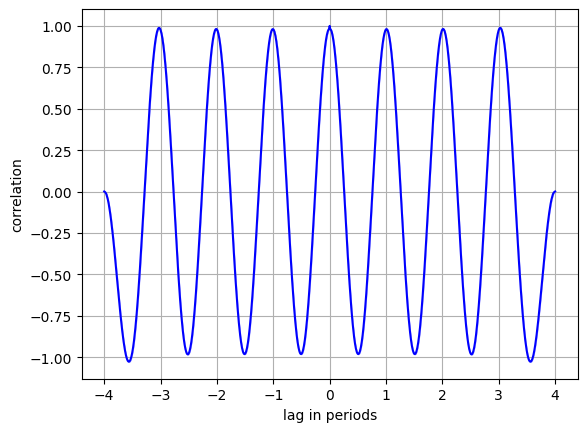

In [4]:
# test_autocrosscorr_sine.py
import numpy as np
from wela.autocrosscorr import autocrosscorr
from wela.plotting import plot_replicate_array

nr = 200
nt = 500
addrandomphase = False
period = 8
t = np.linspace(0, period * 4, nt)
ts = np.tile(t, nr).reshape((nr, nt))
if addrandomphase:
    y = 3 * np.sin(2 * np.pi * ts / period + 2 * np.pi * np.random.rand(nr, 1))
else:
    y = 3 * np.sin(2 * np.pi * ts / period)
data = 10 + y + np.random.normal(0, 0.3, y.shape)

# autocorrelation
ac, lags = autocrosscorr(data, stationary=True)
plot_replicate_array(
    ac,
    t=lags * np.median(np.diff(t)) / period,
    xlabel="lag in periods",
    ylabel="correlation",
)


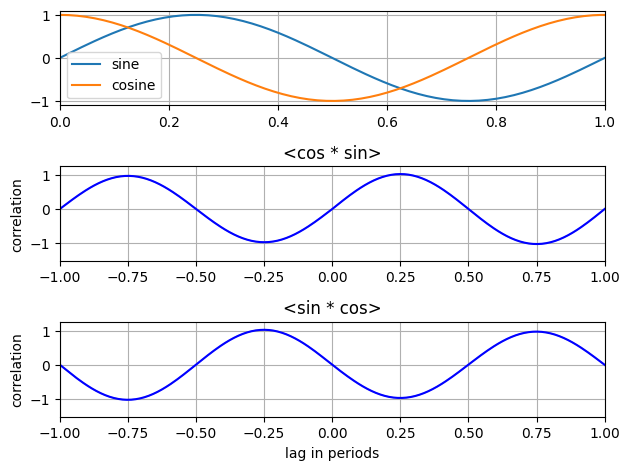

In [ ]:
# test_autocrosscorr_x.py
import numpy as np
import matplotlib.pylab as plt
from wela.autocrosscorr import autocrosscorr
from wela.plotting import plot_replicate_array

nr = 1000
nt = 500
period = 8
noise_sig = 0.01
t = np.linspace(0, period * 4, nt)
ts = np.tile(t, nr).reshape((nr, nt))

final_t = 2 * np.pi * ts / period + np.pi / 4 * np.random.rand(nr, 1)
y = 3 * np.sin(final_t)
s_sin = 10 + y + np.random.normal(0, noise_sig, y.shape)
z = 3 * np.cos(final_t)
s_cos = 10 + z + np.random.normal(0, noise_sig, z.shape)

# correlation
cs, lags = autocrosscorr(s_cos, s_sin)
sc, lags = autocrosscorr(s_sin, s_cos)

# cosine is delayed by period/4 = pi/2 compared to sine
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t / period, np.sin(2 * np.pi * t / period), label="sine")
plt.plot(t / period, np.cos(2 * np.pi * t / period), label="cosine")
plt.legend()
plt.grid()
plt.xlim([0, 1])
plt.subplot(3, 1, 2)
# peaks at 0.25
plot_replicate_array(
    cs,
    t=lags * np.median(np.diff(t)) / period,
    ylabel="correlation",
    title="<cos * sin>",
    show=False,
)
plt.xlim([-1, 1])
plt.subplot(3, 1, 3)
# peaks at -0.25
plot_replicate_array(
    sc,
    t=lags * np.median(np.diff(t)) / period,
    xlabel="lag in periods",
    ylabel="correlation",
    title="<sin * cos>",
    show=False,
)
plt.xlim([-1, 1])
plt.tight_layout()
plt.show()


In [6]:
from wela.autocrosscorr import autocrosscorr
from wela.plotting import plot_replicate_array
import pandas as pd

df = pd.read_csv("by4741_omero20016.csv")
v = df.drop("cellID", axis=1).to_numpy()
ac, lags = autocrosscorr(v)
plot_replicate_array(ac, t=lags * 5 / 60, xlabel="lag", ylabel="correlation")


FileNotFoundError: [Errno 2] No such file or directory: 'by4741_omero20016.csv'